## DQN with ReplayBuffer & TargetNetwork for LunarLender

In [514]:
#assert python version >=3,5
import sys
assert sys.version_info >= (3,5)

from abc import ABC, abstractclassmethod
from collections import deque, namedtuple
import copy
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import random
from time import sleep
from typing import List
import warnings

import gymnasium as gym
assert gym.__version__ >= '0.27.1'
from tqdm import tqdm

try:
    import Box2D
except ImportError:
    warnings.warn('Failed to import', ImportWarning)

   
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

%matplotlib inline

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [377]:
#создание среды
env = gym.make(
    "LunarLander-v2",
    continuous = False,
    gravity = -10.0,
    enable_wind = False,
    wind_power = 15.0,
    turbulence_power = 1.5,
    render_mode="rgb_array"
)

### Определение классов и структур

In [69]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [262]:
class ReplayBuffer:
    '''
        Буфер для накопления хода игры
    '''
    
    def __init__(self, size=1000000):
        '''
        size (int): размер буфера
        '''
        self.buffer = deque(maxlen=size)
        
        
    def len(self):
        '''
        длина буфера
        '''
        return len(self.buffer)
        
        
    def reset(self):
        '''
        очистка буфера
        '''
        self.buffer.clear()

        
    def remember(self, s_t:torch.Tensor, a_t:torch.Tensor, r_t:torch.Tensor, s_t_next:torch.Tensor):
        '''
        сохранение элемента в буфер
        '''
        self.buffer.append(Transition(s_t, a_t, s_t_next, r_t))

        
    def sample(self, batch_size):
        '''
        случайное семплирование из буфера размером batch_size
        '''
        size = min(batch_size, len(self.buffer))
        return random.sample(self.buffer, size)

In [531]:
class DQNBatchNormArchitecture(nn.Module):
    """
        Класс для реализации архитектуры сетей для DQN агента
        Этот класс использует батч нормализация между слоями и дропаут
    """
    
    def __init__(self, n_observations:int, n_actions:int, dropout:float=0.001):
        super(DQNBatchNormArchitecture, self).__init__()
        assert(n_observations >= 1)
        assert(n_actions >= 1)
        assert(dropout > 0.)
        self.Dropout = nn.Dropout(dropout)
        self.ln1 = nn.Linear(n_observations, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.ln2 = torch.nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.ln3 = nn.Linear(64, 16)
        self.bn3 = nn.BatchNorm1d(16)
        self.ln4 = nn.Linear(16, n_actions)
        
    def forward(self, X:torch.Tensor) -> torch.Tensor:
        X = F.relu(self.bn1(self.Dropout(self.ln1(X))))
        X = F.relu(self.bn2(self.Dropout(self.ln2(X))))
        X = F.relu(self.bn3(self.Dropout(self.ln3(X))))
        X = self.ln4(X)
        return X
    

In [568]:
class DQNResidualArchitecture(nn.Module):
    """
        Класс для реализации архитектуры сетей для DQN агента
        Этот класс использует батч нормализация между слоями и дропаут
    """
    
    def __init__(self, input_dim:int, n_actions:int, dropout:float=0.001):
        super(DQNResidualArchitecture, self).__init__()
        assert(n_observations >= 1)
        assert(n_actions >= 1)
        assert(dropout > 0.)
        self.Dropout = nn.Dropout(dropout)
        self.ln1 = nn.Linear(n_observations, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.ln2 = torch.nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.ln3 = nn.Linear(64, 8)
        self.bn3 = nn.BatchNorm1d(8)
        self.ln4 = nn.Linear(8, n_actions)
        
    def forward(self, X:torch.Tensor) -> torch.Tensor:
        residual = X
        out = F.relu(self.bn1(self.Dropout(self.ln1(X.clone()))), inplace=True)
        out = F.relu(self.bn2(self.Dropout(self.ln2(out))))
        out = F.relu(self.bn3(self.Dropout(self.ln3(out))))
        out = out + residual
        out = out.view(out.size(0),-1)
        X = self.ln4(out)
        return X
    

In [488]:
class Agent(ABC):
    """
    Базовый класс Агент для различных алгоритмов rl


    Attributes
    ----------
    _env : gym.Env
        среда для исследования
    _device : torch.cude.device
        устройство
    _epsilon_up : float
        верхняя граница epsilon  
    _epsilon_low : float
        нижняя граница epsilon  
    _epsilon : float
        текущее значение epsilon
    _lr : float
        лерниниг рейт обучения
    _gamma : float
        коэффициент дисконтирования
        


    Methods
    -------
    learn(self, num_episodes:int) -> None:        
        выполнить обучение агента
    
    load(self, path:str) -> None:        
        выполнить загрузку весов и данных агента из сторейджа
    
    predict(self, state:np.ndarray) -> np.ndarray:    
        выполнить прогноз действия для переданного состояниея
        
    save(self, path:str) -> None:                
        сохранить данные агента и веса в сторейдж
    
    _is_exploration() -> bool
        случайным образом решает выполнить ли сейчас Exploration либо Exploatation среды
        
    _act(self, state:np.ndarray) -> np.ndarray:
        выполнить один шаг эпизода
        
     _decay_epsilon(self):
         модифицировать значене epsilon для жадной политики на новом шаге
         
     _update_policy(self) -> None:
         выполнить обновление политики агента
    """

    
    def __init__(self, env: gym.Env, device:torch.cuda.device, epsilon_up:float=1.0, epsilon_low:float=0.05, lr:float=1e-4, gamma:float=0.99):
        assert(env is not None)
        assert(device is not None)
        assert(epsilon_up <= 1. and epsilon_up > epsilon_low)
        assert(epsilon_low >= 0. and epsilon_low < epsilon_up)
        assert(lr > 0 and lr < 1)
        assert(gamma >= 0.9 and gamma < 1)
        
        self._env = env
        self._device = device
        self._epsilon_up = epsilon_up
        self._epsilon_low = epsilon_low
        self._epsilon = epsilon_up
        self._lr = lr
        self._gamma = gamma
        
        self._total_rewards = []
        self._total_steps = 0
    
    @abstractclassmethod
    def learn(self, num_episodes:int) -> None:        
        pass

    @abstractclassmethod
    def load(self, path:str) -> None:        
        pass

    @abstractclassmethod
    def predict(self, state:np.ndarray) -> np.ndarray:    
        pass
    
    @abstractclassmethod
    def save(self, path:str) -> None:        
        pass
    
    @abstractclassmethod
    def _act(self, state:np.ndarray) -> np.ndarray:
        pass

    @abstractclassmethod
    def _decay_epsilon(self):
        pass

    def _is_exploration(self) -> bool:
        return np.random.uniform(0,1) < self._epsilon    

    @abstractclassmethod
    def _update_policy(self) -> None:
        pass

In [520]:
class DQNAgent(Agent):
    
    '''
    
    Класс реализующий метод DQN 


    Attributes
    ----------
    _reply_buffer : ReplayBuffer
        буфер накопления состояний, наград и действий среды
    _epsilon_decay : int
        на сколько шагов снижать epsilon
    _tau : float
        коэффициент обновления весов target сети  
    _batch_size: int
        размер батча обучения
    _policy_net: torch.nn.Module
        сеть для определения политики агента
    _target_net: torch.nn.Module
        сеть для расчета state values
    _loss_function : torch.nn.modules._Loss
        лосс функция
    _optimizer : torch.optim.Optimizer
        оптимизатор
    

    Methods
    -------
    
    learn(self, num_episodes:int) -> None:        
        выполнить обучение агента
    
    load(self, path:str) -> None:        
        выполнить загрузку весов и данных агента из сторейджа
    
    predict(self, state:np.ndarray) -> np.ndarray:    
        выполнить прогноз действия для переданного состояниея
        
    save(self, path:str) -> None:                
        сохранить данные агента и веса в сторейдж
    
    _act(self, state:np.ndarray) -> np.ndarray:
        выполнить один шаг эпизода
        
     _decay_epsilon(self):
         модифицировать значене epsilon для жадной политики на новом шаге
         
     _update_policy(self) -> None:
         выполнить обновление политики агента
    
    _synchronize(self):
        синхронизация весов target сети с весами policy сети
    

    '''
    
    def __init__(self, env:gym.Env, reply_buffer:ReplayBuffer, architecture:nn.Module=None, device:torch.cuda.device=None, 
                 lr:float=1e-4, gamma:float=0.99, tau:float=0.005, epsilon_up:float=1.0, epsilon_low:float=0.05, epsilon_decay:int=1000, batch_size:int=128):
        super().__init__(env, device, epsilon_up, epsilon_low, lr, gamma)

        assert(reply_buffer is not None)
        self._reply_buffer = reply_buffer
        self._reply_buffer.reset()
        assert(epsilon_decay > 0)
        self._epsilon_decay = epsilon_decay
        assert(tau > 0. and tau < 1.)
        self._tau = tau
        assert(batch_size > 0)        
        self._batch_size = batch_size
        
        
        if architecture is None:
            self._policy_net = torch.nn.Sequential(
                torch.nn.Linear(env.observation_space.shape[0], 128),
                torch.nn.ReLU(),
                torch.nn.Linear(128, 64),
                torch.nn.ReLU(),
                torch.nn.Linear(64, 16),
                torch.nn.ReLU(),
                torch.nn.Linear(16, env.action_space.n),
            )
        else:
            self._policy_net = architecture
        self._target_net = copy.deepcopy(self._policy_net)
        self._policy_net = self._policy_net.to(self._device)
        self._target_net = self._target_net.to(self._device)
        self._target_net.eval()
        
        self._loss_function = nn.SmoothL1Loss()
        
        self._optimizer = optim.AdamW(self._policy_net.parameters(), lr=self._lr,  amsgrad=True)
        

        
    def _synchronize(self):
        '''
            синхронизация весов target сети с весами policy сети
        '''
        target_net_state_dict = self._target_net.state_dict()
        policy_net_state_dict = self._policy_net.state_dict()
        
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*self._tau + target_net_state_dict[key]*(1-self._tau)
        self._target_net.load_state_dict(target_net_state_dict)
        
        
    def _act(self, state:np.ndarray) -> np.ndarray:
        '''
            выполнить один шаг эпизода из состоянмя state
        '''
        if self._is_exploration():
            return torch.tensor([[self._env.action_space.sample()]], device=self._device, dtype=torch.long)
        else:
            return self.predict(state)
    
    
    def predict(self, state:np.ndarray) -> np.ndarray:   
        '''
            выполнить прогноз действия для переданного состояниея state
        '''
        self._policy_net.eval()
        state = torch.as_tensor(state).to(self._device)
        with torch.inference_mode():
            return self._policy_net(state).max(1).indices.view(1, 1)
        
    
    def _update_policy(self) -> None:
        '''
            Обновление политики
        '''
        
        if self._reply_buffer.len() < self._batch_size:
            return
        
        batch = self._reply_buffer.sample(self._batch_size)
        batch = Transition(*zip(*batch))
        states = torch.cat(batch.state)
        actions = torch.cat(batch.action)
        rewards = torch.cat(batch.reward)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=self._device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).to(self._device)
        
        self._policy_net.train()
        state_values = self._policy_net(states).gather(1, actions)
        target_state_values = torch.zeros(len(batch.state), dtype=torch.float32, device=self._device)
        with torch.inference_mode():
            target_state_values[non_final_mask] = self._target_net(non_final_next_states).max(1).values
        
        target_state_values = self._gamma * target_state_values + rewards
        loss = self._loss_function(state_values, target_state_values.unsqueeze(1))
        self._optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(self._policy_net.parameters(), 100)
        self._optimizer.step()
        

    def _decay_epsilon(self) -> None:
        '''
            Уменьшение epsilon на шаге обучения
        '''
        self._epsilon = self._epsilon_low + np.math.exp(-1. * self._total_steps / self._epsilon_decay)*(self._epsilon_up - self._epsilon_low)
        
   
    def learn(self, num_episodes:int) -> None:
        '''
            Выполнить обучение за num_episodes эпизодов
        '''
        for i_episode in tqdm(range(num_episodes)):
            episode_reward = 0
            state, info = self._env.reset()
            state = torch.tensor(state, dtype=torch.float32, device=self._device).unsqueeze(0)
            done = False
            step = 0
            while not done:
                action = self._act(state)
                #step the game
                next_state, reward, terminated, truncated, _ = self._env.step(action.item())
                done = terminated or truncated
                episode_reward += reward
                if terminated:
                    next_state = None
                else:
                    next_state = torch.tensor(next_state, dtype=torch.float32, device=self._device).unsqueeze(0)
                reward = torch.tensor([reward], device=self._device)
                self._reply_buffer.remember(state, action, reward, next_state)
                
                self._update_policy()
                self._synchronize()
                self._decay_epsilon()
                
                state = next_state
                self._total_steps += 1
                #next step
                
            self._total_rewards.append(episode_reward)

            
    def save(self, path):
        '''
            Сохранить агента
        '''
        torch.save(obj={"weights":self._policy_net.state_dict(), "rewards":self._total_rewards}, f=f"{path}.pt")
        
        
    def load(self, path):
        '''
            Загрузить агента
        '''
        obj = torch.load(f=f"{path}.pt")
        self._policy_net.load_state_dict(obj["weights"])
        self._target_net.load_state_dict(self._policy_net.state_dict())
        self._total_rewards = obj["rewards"]

### Обучение нового агента

In [575]:
architecture = DQNResidualArchitecture(env.observation_space.shape[0], env.action_space.n)
agent = DQNAgent(env=env, architecture=None, device=device, reply_buffer=ReplayBuffer(size=10000))

In [586]:
agent.learn(500)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:53<00:00,  1.14s/it]


In [589]:
agent.save("models/model_base")

### Можно загрузить данные сохраненного агента

In [590]:
agent = DQNAgent(env=env, architecture=None, device=device, reply_buffer=ReplayBuffer(size=10000))
agent.load("models/model_base")

### Оценка и визуализация

Было выполнено сравнение нескольких архитектур: базовой (многослойный персептрон), базовой+блоки нормализации, базовой+нормализация+residual connection
В итоге самой продуктивной моделью оказалась именно базовая.
Остальные модели сохранены также, но они за 500 эпизодов не вышли на положительный reward

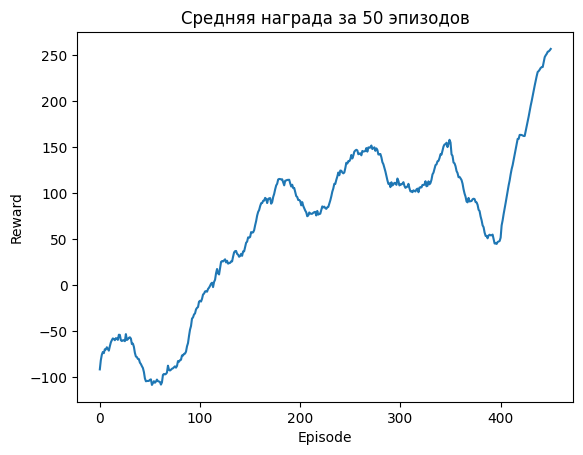

In [591]:
window_size = 50
moving_avg = np.convolve(agent._total_rewards, np.ones(window_size)/window_size, mode='valid')
plt.plot(moving_avg)
plt.title('Средняя награда за 50 эпизодов')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

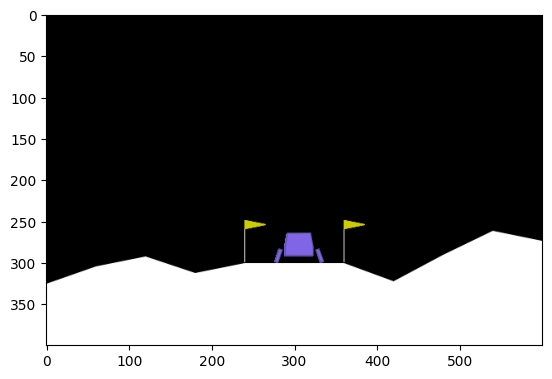

In [592]:
state, info = env.reset(seed=12333)
for i in range(env.spec.max_episode_steps):
    if i % 5 == 0:
        plt.imshow(env.render())
        display.display(plt.gcf())    
        display.clear_output(wait=True)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    action = agent.predict(state)
    state, reward, terminated, truncated, info = env.step(action.item())
    if terminated or truncated:
        break
    sleep(0)     